# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science 

## Standard Section 4: Regularization and Model Selection

**Harvard University**<br/>
**Fall 2019**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, and Chris Tanner<br/>
**Section Leaders**: Marios Mattheakis, Abhimanyu (Abhi) Vasishth, Robbert (Rob) Struyven<br/>

<hr style='height:2px'>

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("http://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

For this section, our goal is to get you familiarized with Regularization in Multiple Linear Regression and to start thinking about Model and Hyper-Parameter Selection. 

Specifically, we will:

- Load in the King County House Price Dataset
- Perform some basic EDA
- Split the data up into a training, **validation**, and test set (we'll see why we need a validation set)
- Scale the variables (by standardizing them) and seeing why we need to do this
- Make our multiple & polynomial regression models (like we did in the previous section)
- Learn what **regularization** is and how it can help
- Understand **ridge** and **lasso** regression
- Get an introduction to **cross-validation** using RidgeCV and LassoCV

<img src="../fig/meme.png" width="400">

In [2]:
# Data and Stats packages
import numpy as np
import pandas as pd
pd.set_option('max_columns', 200)

# Visualization packages
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings("ignore")

# EDA: House Prices Data From Kaggle

For our dataset, we'll be using the house price dataset from [King County, WA](https://en.wikipedia.org/wiki/King_County,_Washington). The dataset is from [Kaggle](https://www.kaggle.com/harlfoxem/housesalesprediction). 

The task is to build a regression model to **predict the price**, based on different attributes. First, let's do some EDA.

In [3]:
# Load the dataset 
house_df = pd.read_csv('../data/kc_house_data.csv')
house_df = house_df.sample(frac=1, random_state=42)[0:4000]
print(house_df.shape)
print(house_df.dtypes)
house_df.head()

(4000, 21)
id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
735,2591820310,20141006T000000,365000.0,4,2.25,2070,8893,2.0,0,0,4,8,2070,0,1986,0,98058,47.4388,-122.162,2390,7700
2830,7974200820,20140821T000000,865000.0,5,3.00,2900,6730,1.0,0,0,5,8,1830,1070,1977,0,98115,47.6784,-122.285,2370,6283
4106,7701450110,20140815T000000,1038000.0,4,2.50,3770,10893,2.0,0,2,3,11,3770,0,1997,0,98006,47.5646,-122.129,3710,9685
16218,9522300010,20150331T000000,1490000.0,3,3.50,4560,14608,2.0,0,2,3,12,4560,0,1990,0,98034,47.6995,-122.228,4050,14226
19964,9510861140,20140714T000000,711000.0,3,2.50,2550,5376,2.0,0,0,3,9,2550,0,2004,0,98052,47.6647,-122.083,2250,4050


Now let's check for null values and look at the datatypes within the dataset.

In [4]:
house_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 735 to 3455
Data columns (total 21 columns):
id               4000 non-null int64
date             4000 non-null object
price            4000 non-null float64
bedrooms         4000 non-null int64
bathrooms        4000 non-null float64
sqft_living      4000 non-null int64
sqft_lot         4000 non-null int64
floors           4000 non-null float64
waterfront       4000 non-null int64
view             4000 non-null int64
condition        4000 non-null int64
grade            4000 non-null int64
sqft_above       4000 non-null int64
sqft_basement    4000 non-null int64
yr_built         4000 non-null int64
yr_renovated     4000 non-null int64
zipcode          4000 non-null int64
lat              4000 non-null float64
long             4000 non-null float64
sqft_living15    4000 non-null int64
sqft_lot15       4000 non-null int64
dtypes: float64(5), int64(15), object(1)
memory usage: 687.5+ KB


In [5]:
house_df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,4.000000e+03,4.000000e+03,4000.000000,4000.000000,4000.000000,4.000000e+03,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.00000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.00000,4000.00000
mean,4.586542e+09,5.497522e+05,3.379250,2.116563,2096.645250,1.616511e+04,1.475000,0.007750,0.232500,3.420750,7.668250,1792.465000,304.18025,1970.564250,89.801500,98078.035500,47.560091,-122.214060,1997.75900,12790.67800
std,2.876700e+09,3.890505e+05,0.922568,0.783175,957.785141,5.120888e+04,0.530279,0.087703,0.768174,0.646393,1.194173,849.986192,455.26354,29.141872,413.760082,54.073374,0.139070,0.141879,701.60987,26085.20301
min,1.000102e+06,8.250000e+04,0.000000,0.000000,384.000000,5.720000e+02,1.000000,0.000000,0.000000,1.000000,4.000000,384.000000,0.00000,1900.000000,0.000000,98001.000000,47.155900,-122.515000,620.00000,659.00000
25%,2.126074e+09,3.249500e+05,3.000000,1.750000,1420.000000,5.200000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1180.000000,0.00000,1951.000000,0.000000,98033.000000,47.468175,-122.328000,1490.00000,5200.00000
50%,3.889350e+09,4.550000e+05,3.000000,2.250000,1920.000000,7.675000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1550.000000,0.00000,1974.500000,0.000000,98065.000000,47.573800,-122.231000,1840.00000,7628.00000
75%,7.334526e+09,6.541250e+05,4.000000,2.500000,2570.000000,1.087125e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2250.000000,590.00000,1995.000000,0.000000,98118.000000,47.679100,-122.127000,2370.00000,10240.00000
max,9.842300e+09,5.570000e+06,11.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4130.00000,2015.000000,2015.000000,98199.000000,47.777500,-121.315000,5790.00000,560617.00000


Let's choose a subset of columns here. **NOTE**: The way I'm selecting columns here is not principled and is just for convenience. In your homework assignments (and in real life), we expect you to choose columns more rigorously.

1. `bedrooms`
2. `bathrooms`
3. `sqft_living`
4. `sqft_lot`
5. `floors`
6. `sqft_above`
7. `sqft_basement`
8. `lat`
9. `long`
10. **`price`**: Our response variable

In [6]:
cols_of_interest = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'sqft_above', 'sqft_basement',
                    'lat', 'long', 'price']
house_df = house_df[cols_of_interest]

# Convert house price to 1000s of dollars
house_df['price'] = house_df['price']/1000

Let's see how the response variable (`price`) is distributed

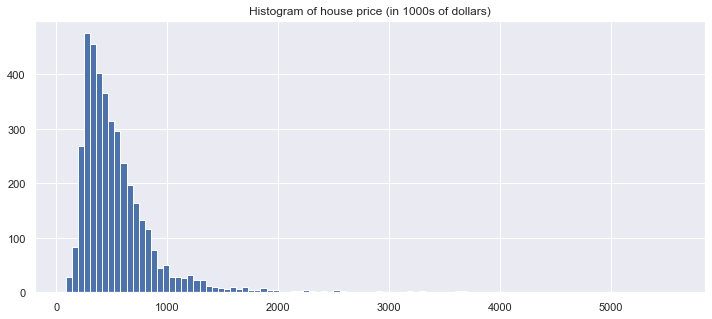

In [7]:
fig, ax = plt.subplots(figsize=(12,5))
ax.hist(house_df['price'], bins=100)
ax.set_title('Histogram of house price (in 1000s of dollars)');

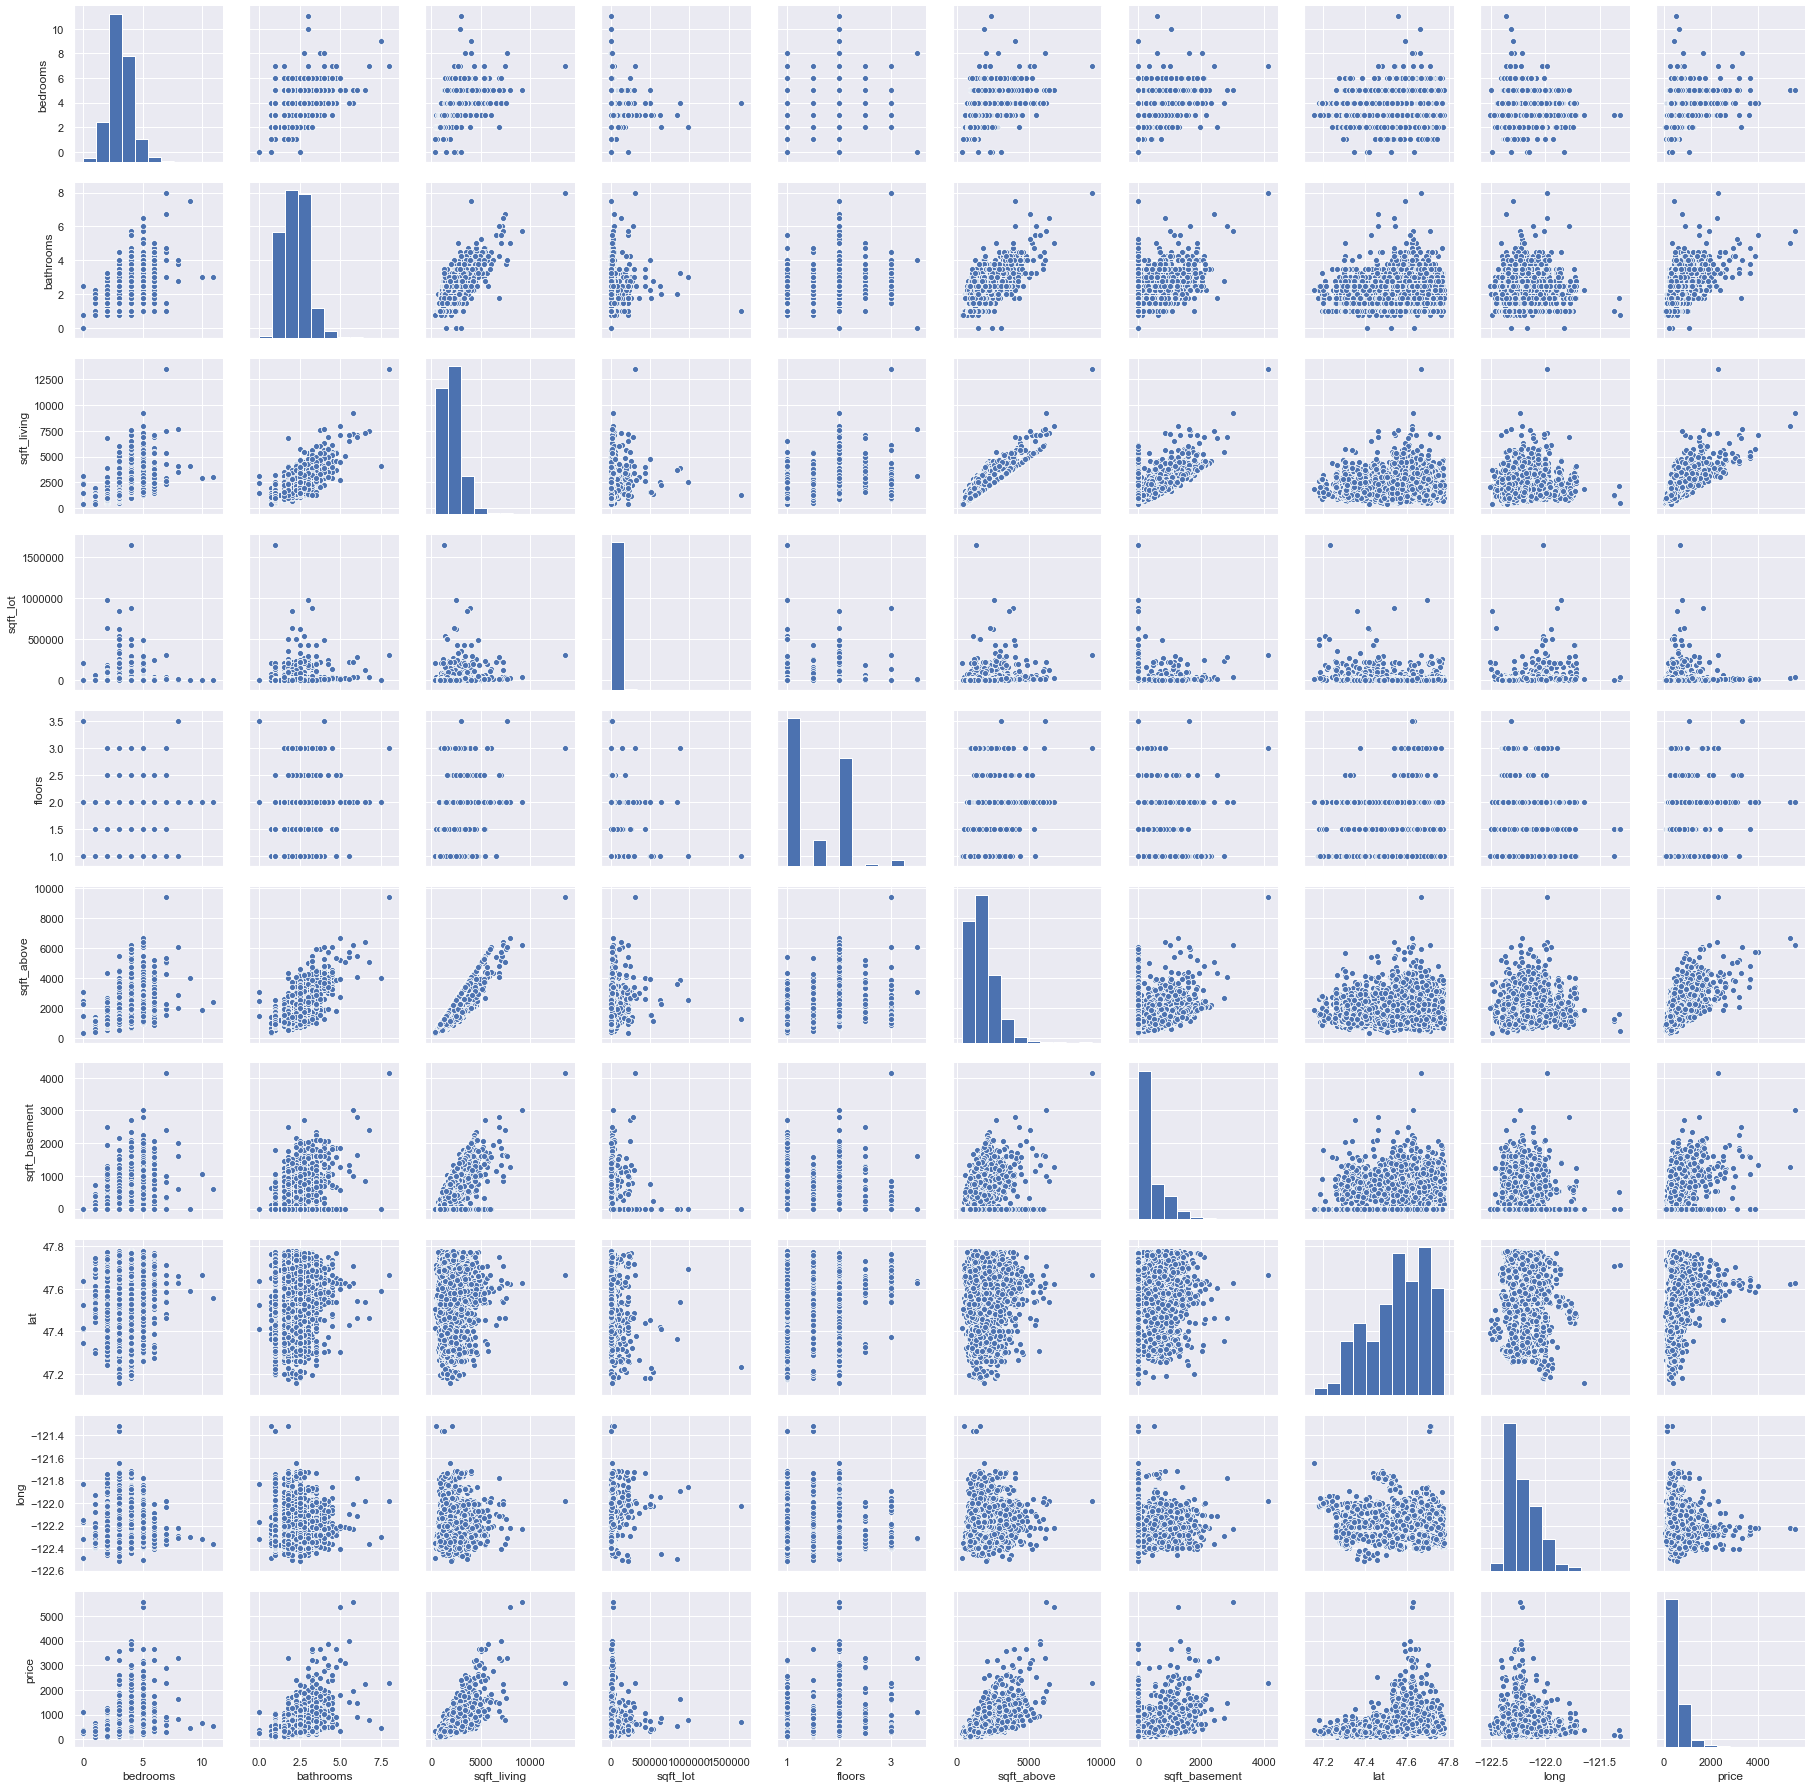

In [8]:
# This takes a bit of time but is worth it!!
sns.pairplot(house_df);

## Train-Validation-Test Split

Up until this point, we have only had a train-test split. Why are we introducing a validation set? What's the point?

This is the general idea: 

1. **Training Set**: Data you have seen. You train different types of models with various different hyper-parameters and regularization parameters on this data. 


2. **Validation Set**: Used to compare different models. We use this step to tune our hyper-parameters i.e. find the optimal set of hyper-parameters (such as $k$ for k-NN or our $\beta_i$ values or number of degrees of our polynomial for linear regression). Pick your best model here. 



3. **Test Set**: Using the best model from the previous step, simply report the score e.g. R^2 score, MSE or any metric that you care about, of that model on your test set. **DON'T TUNE YOUR PARAMETERS HERE!**. Why, I hear you ask? Because we want to know how our model might do on data it hasn't seen before. We don't have access to this data (because it may not exist yet) but the test set, which we haven't seen or touched so far, is a good way to mimic this new data. 

Let's do 60% train, 20% validation, 20% test for this dataset.

In [9]:
from sklearn.model_selection import train_test_split

# first split the data into a train-test split and don't touch the test set yet
train_df, test_df = train_test_split(house_df, test_size=0.2, random_state=42)

# next, split the training set into a train-validation split
# the test-size is 0.25 since we are splitting 80% of the data into 20% and 60% overall
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42)

print('Train Set: {0:0.2f}%'.format(100*train_df.size/house_df.size))
print('Validation Set: {0:0.2f}%'.format(100*val_df.size/house_df.size))
print('Test Set: {0:0.2f}%'.format(100*test_df.size/house_df.size))

Train Set: 60.00%
Validation Set: 20.00%
Test Set: 20.00%


# Modeling

In the [last section](https://github.com/Harvard-IACS/2019-CS109A/tree/master/content/sections/section3), we went over the mechanics of Multiple Linear Regression and created models that had interaction terms and polynomial terms. Specifically, we dealt with the following sorts of models. 

$$
y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \dots + \beta_M x_M
$$

Let's adopt a similar process here and get a few different models.

## Creating a Design Matrix

From our model setup in the equation in the previous section, we obtain the following: 

$$
Y = \begin{bmatrix}
y_1 \\
y_2 \\
\vdots \\
y_n
\end{bmatrix}, \quad X = \begin{bmatrix}
x_{1,1} & x_{1,2} & \dots & x_{1,M} \\
x_{2,1} & x_{2,2} & \dots & x_{2,M} \\
\vdots & \vdots & \ddots & \vdots \\
x_{n,1} & x_{n,2} & \dots & x_{n,M} \\
\end{bmatrix}, \quad \beta = \begin{bmatrix}
\beta_1 \\
\beta_2 \\
\vdots \\
\beta_M
\end{bmatrix}, \quad \epsilon = \begin{bmatrix}
\epsilon_1 \\
\epsilon_2 \\
\vdots \\
\epsilon_n
\end{bmatrix},
$$

$X$ is an n$\times$M matrix: this is our **design matrix**, $\beta$ is an M-dimensional vector (an M$\times$1 matrix), and $Y$ is an n-dimensional vector (an n$\times$1 matrix). In addition, we know that $\epsilon$ is an n-dimensional vector (an n$\times$1 matrix).

In [10]:
X = train_df[cols_of_interest]
y = train_df['price']
print(X.shape)
print(y.shape)

(2400, 10)
(2400,)


## Scaling our Design Matrix

### Warm-Up Exercise

Warm-Up Exercise: for which of the following do the units of the predictors matter (e.g., trip length in minutes vs seconds; temperature in F or C)? A similar question would be: for which of these models do the magnitudes of values taken by different predictors matter? 

(We will go over Ridge and Lasso Regression in greater detail later)

- k-NN (Nearest Neighbors regression)
- Linear regression
- Lasso regression
- Ridge regression

**Solutions**

- kNN: **yes**. Scaling affects distance metric, which determines what "neighbor" means
- Linear regression: **no**. Multiply predictor by $c$ -> divide coef by $c$.
- Lasso: **yes**: If we divided coef by $c$, then corresponding penalty term is also divided by $c$.
- Ridge: **yes**: Same as Lasso, except penalty divided by $c^2$.

### Standard Scaler (Standardization)
 
[Here's](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) the scikit-learn implementation of the standard scaler. What is it doing though? Hint: you may have seen this in STAT 110 or another statistics course multiple times.

$$
z = \frac{x-\mu}{\sigma}
$$

In the above setup: 

- $z$ is the standardized variable
- $x$ is the variable before standardization
- $\mu$ is the mean of the variable before standardization
- $\sigma$ is the standard deviation of the variable before standardization

Let's see an example of how this works:

In [1]:
from sklearn.preprocessing import StandardScaler

x = house_df['sqft_living']
mu = x.mean()
sigma = x.std()
z = (x-mu)/sigma

# reshaping x to be a n by 1 matrix since that's how scikit learn likes data for standardization
x_reshaped = np.array(x).reshape(-1,1)
z_sklearn = StandardScaler().fit_transform(x_reshaped)

# Plotting the histogram of the variable before standardization
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(24,5))
ax = ax.ravel()

ax[0].hist(x, bins=100)
ax[0].set_title('Histogram of sqft_living before standardization')

ax[1].hist(z, bins=100)
ax[1].set_title('Manually standardizing sqft_living')

ax[2].hist(z_sklearn, bins=100)
ax[2].set_title('Standardizing sqft_living using scikit learn');

# making things a dataframe to check if they work
pd.DataFrame({'x': x, 'z_manual': z, 'z_sklearn': z_sklearn.flatten()}).describe()

NameError: name 'house_df' is not defined

### Min-Max Scaler (Normalization)

[Here's](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) the scikit-learn implementation of the standard scaler. What is it doing though? 

$$
x_{new} = \frac{x-x_{min}}{x_{max}-x_{min}}
$$

In the above setup: 

- $x_{new}$ is the normalized variable
- $x$ is the variable before normalized
- $x_{max}$ is the max value of the variable before normalization
- $x_{min}$ is the min value of the variable before normalization

Let's see an example of how this works:

,x,x_new_manual,x_new_sklearn
count,4000.000000,4000.000000,4000.000000
mean,2096.645250,0.130180,0.130180
std,957.785141,0.072802,0.072802
min,384.000000,0.000000,0.000000
25%,1420.000000,0.078747,0.078747
50%,1920.000000,0.116753,0.116753
75%,2570.000000,0.166160,0.166160
max,13540.000000,1.000000,1.000000


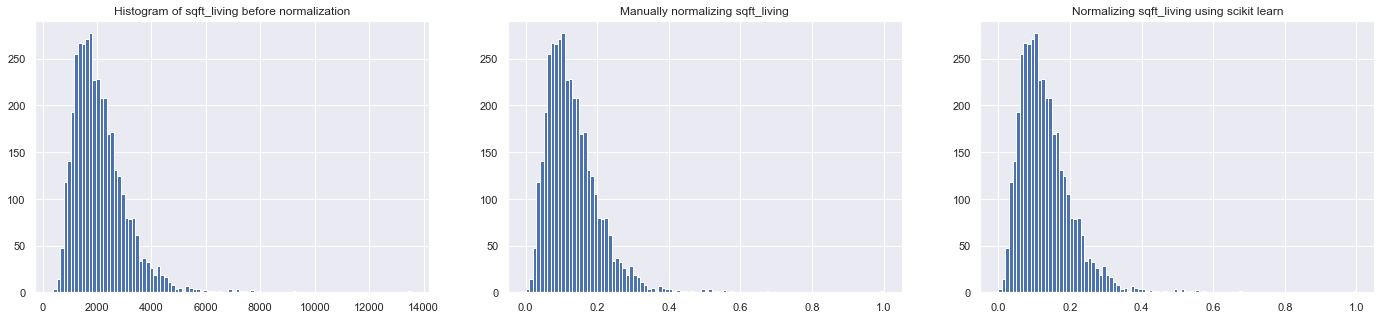

In [13]:
from sklearn.preprocessing import MinMaxScaler

x = house_df['sqft_living']
x_new = (x-x.min())/(x.max()-x.min())

# reshaping x to be a n by 1 matrix since that's how scikit learn likes data for normalization
x_reshaped = np.array(x).reshape(-1,1)
x_new_sklearn = MinMaxScaler().fit_transform(x_reshaped)

# Plotting the histogram of the variable before normalization
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(24,5))
ax = ax.ravel()

ax[0].hist(x, bins=100)
ax[0].set_title('Histogram of sqft_living before normalization')

ax[1].hist(x_new, bins=100)
ax[1].set_title('Manually normalizing sqft_living')

ax[2].hist(x_new_sklearn, bins=100)
ax[2].set_title('Normalizing sqft_living using scikit learn');

# making things a dataframe to check if they work
pd.DataFrame({'x': x, 'x_new_manual': x_new, 'x_new_sklearn': x_new_sklearn.flatten()}).describe()

**The million dollar question**

Should I standardize or normalize my data? [This](https://medium.com/@rrfd/standardize-or-normalize-examples-in-python-e3f174b65dfc), [this](https://medium.com/@swethalakshmanan14/how-when-and-why-should-you-normalize-standardize-rescale-your-data-3f083def38ff) and [this](https://stackoverflow.com/questions/32108179/linear-regression-normalization-vs-standardization) are useful resources that I highly recommend. But in a nutshell, what they say is the following: 

**Pros of Normalization**

1. Normalization (which makes your data go from 0-1) is widely used in image processing and computer vision, where pixel intensities are non-negative and are typically scaled from a 0-255 scale to a 0-1 range for a lot of different algorithms. 
2. Normalization is also very useful in neural networks (which we will see later in the course) as it leads to the algorithms converging faster.
3. Normalization is useful when your data does not have a discernible distribution and you are not making assumptions about your data's distribution.

**Pros of Standardization**

1. Standardization maintains outliers (do you see why?) whereas normalization makes outliers less obvious. In applications where outliers are useful, standardization should be done.
2. Standardization is useful when you assume your data comes from a Gaussian distribution (or something that is approximately Gaussian). 

**Some General Advice**

1. We learn parameters for standardization ($\mu$ and $\sigma$) and for normalization ($x_{min}$ and $x_{max}$). Make sure these parameters are learned on the training set i.e use the training set parameters even when normalizing/standardizing the test set. In sklearn terms, fit your scaler on the training set and use the scaler to transform your test set and validation set (**don't re-fit your scaler on test set data!**).
2. The point of standardization and normalization is to make your variables take on a more manageable scale. You should ideally standardize or normalize all your variables at the same time. 
3. Standardization and normalization is not always needed and is not an automatic thing you have to do on any data science homework!! Do so sparingly and try to justify why this is needed.

**Interpreting Coefficients**

A great quote from [here](https://stats.stackexchange.com/questions/29781/when-conducting-multiple-regression-when-should-you-center-your-predictor-varia)

> [Standardization] makes it so the intercept term is interpreted as the expected value of 𝑌𝑖 when the predictor values are set to their means. Otherwise, the intercept is interpreted as the expected value of 𝑌𝑖 when the predictors are set to 0, which may not be a realistic or interpretable situation (e.g. what if the predictors were height and weight?)

### Standardizing our Design Matrix

In [15]:
features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'sqft_above', 'sqft_basement',
            'lat', 'long']

X_train = train_df[features]
y_train = np.array(train_df['price']).reshape(-1,1)

X_val = val_df[features]
y_val = np.array(val_df['price']).reshape(-1,1)

X_test = test_df[features]
y_test = np.array(test_df['price']).reshape(-1,1)

scaler = StandardScaler().fit(X_train)

# This converts our matrices into numpy matrices
X_train_t = scaler.transform(X_train)
X_val_t = scaler.transform(X_val)
X_test_t = scaler.transform(X_test)

# Making the numpy matrices pandas dataframes
X_train_df = pd.DataFrame(X_train_t, columns=features)
X_val_df = pd.DataFrame(X_val_t, columns=features)
X_test_df = pd.DataFrame(X_test_t, columns=features)

display(X_train_df.describe())
display(X_val_df.describe())
display(X_test_df.describe())

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,lat,long
count,2.400000e+03,2.400000e+03,2.400000e+03,2.400000e+03,2.400000e+03,2.400000e+03,2.400000e+03,2.400000e+03,2.400000e+03
mean,2.250977e-16,4.503342e-17,1.471971e-16,-2.406640e-17,2.680263e-16,-8.234154e-18,-1.709281e-16,4.928733e-14,4.897231e-14
std,1.000208e+00,1.000208e+00,1.000208e+00,1.000208e+00,1.000208e+00,1.000208e+00,1.000208e+00,1.000208e+00,1.000208e+00
min,-3.618993e+00,-2.677207e+00,-1.766429e+00,-3.364203e-01,-8.897850e-01,-1.636285e+00,-6.704685e-01,-2.937091e+00,-2.084576e+00
25%,-4.009185e-01,-4.598398e-01,-7.087691e-01,-2.324570e-01,-8.897850e-01,-7.089826e-01,-6.704685e-01,-6.732889e-01,-8.086270e-01
50%,-4.009185e-01,1.736938e-01,-1.933403e-01,-1.774091e-01,-8.897850e-01,-2.895998e-01,-6.704685e-01,8.468878e-02,-1.278830e-01
75%,6.717731e-01,4.904606e-01,4.973342e-01,-1.033061e-01,9.975186e-01,5.375162e-01,6.315842e-01,8.607566e-01,6.455277e-01
max,7.107923e+00,7.459330e+00,1.179553e+01,1.945618e+01,3.828474e+00,8.878574e+00,8.291994e+00,1.560846e+00,6.062967e+00


,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,lat,long
count,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,0.018772,0.041444,0.024401,0.016506,0.026737,0.044415,-0.031370,-0.056059,0.016900
std,0.982683,0.997594,0.989079,1.074079,0.991645,0.993807,0.999638,1.008010,1.028649
min,-2.546302,-1.726907,-1.626232,-0.328715,-0.889785,-1.477851,-0.670469,-2.693960,-2.141602
25%,-0.400918,-0.459840,-0.677843,-0.234254,-0.889785,-0.685684,-0.670469,-0.737509,-0.815755
50%,-0.400918,0.173694,-0.172723,-0.177521,0.053867,-0.266301,-0.670469,0.031504,-0.088678
75%,0.671773,0.490461,0.487026,-0.113533,0.997519,0.595764,0.550206,0.817340,0.597412
max,8.180614,4.925195,7.321611,21.716593,2.884822,5.139078,5.839795,1.554333,6.369480


,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,lat,long
count,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,0.010727,-0.018346,-0.029080,0.052808,0.006684,-0.021866,-0.020484,-0.005631,0.000897
std,0.965422,0.963162,0.946367,1.569619,1.012587,0.955805,0.938793,1.022830,1.028155
min,-3.618993,-2.677207,-1.657158,-0.335005,-0.889785,-1.524449,-0.670469,-2.656332,-1.778063
25%,-0.400918,-0.459840,-0.701038,-0.229160,-0.889785,-0.708983,-0.670469,-0.624084,-0.789024
50%,-0.400918,0.173694,-0.183032,-0.174051,-0.889785,-0.295425,-0.670469,0.174054,-0.174216
75%,0.671773,0.490461,0.417443,-0.100683,0.997519,0.479269,0.588182,0.842124,0.604540
max,4.962540,3.658128,5.785633,36.746809,3.828474,5.010933,4.016921,1.544926,6.412249


In [16]:
scaler = StandardScaler().fit(y_train)
y_train = scaler.transform(y_train)
y_val = scaler.transform(y_val)
y_test = scaler.transform(y_test)

## One-Degree Polynomial Model

In [17]:
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS

model_1 = OLS(np.array(y_train).reshape(-1,1), sm.add_constant(X_train_df)).fit()
model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.586
Model:                            OLS   Adj. R-squared:                  0.584
Method:                 Least Squares   F-statistic:                     422.3
Date:                Sun, 20 Oct 2019   Prob (F-statistic):               0.00
Time:                        16:16:05   Log-Likelihood:                -2348.5
No. Observations:                2400   AIC:                             4715.
Df Residuals:                    2391   BIC:                             4767.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -5.145e-15      0.013  -3.91e-13      1.000      -0.026       0.026
bedrooms         -0.1592      0.017     -9.505      0.000      -0.192      -0.126
bathrooms         0.0422      0.022      1.914      0.056      -0.001       0.085
sqft_living       0.4011      0.011     36.238      0.000       0.379       0.423
sqft_lot         -0.0058      0.014     -0.420      0.675      -0.033       0.021
floors           -0.0470      0.017     -2.690      0.007      -0.081      -0.013
sqft_above        0.3866      0.013     30.254      0.000       0.362       0.412
sqft_basement     0.1242      0.014      8.651      0.000       0.096       0.152
lat               0.2414      0.013     17.983      0.000       0.215       0.268
long             -0.1388      0.014     -9.605      0.000      -0.167      -0.110
==============================================================================
Omnibus:                     1646.401   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            52596.394
Skew:                           2.797   Prob(JB):                         0.00
Kurtosis:                      25.241   Cond. No.                     2.95e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 9.63e-36. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## Two-Degree Polynomial Model

In [19]:
def add_square_terms(df):
    df = df.copy()
    cols = df.columns.copy()
    for col in cols:
        df['{}^2'.format(col)] = df[col]**2
    return df

X_train_df_2 = add_square_terms(X_train)
X_val_df_2 = add_square_terms(X_val)

# Standardizing our added coefficients
cols = X_train_df_2.columns
scaler = StandardScaler().fit(X_train_df_2)
X_train_df_2 = pd.DataFrame(scaler.transform(X_train_df_2), columns=cols)
X_val_df_2 = pd.DataFrame(scaler.transform(X_val_df_2), columns=cols)

print(X_train_df.shape, X_train_df_2.shape)

# Also check using the describe() function that the mean and standard deviations are the way we want them
X_train_df_2.head()

(2400, 9) (2400, 18)


,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,lat,long,bedrooms^2,bathrooms^2,sqft_living^2,sqft_lot^2,floors^2,sqft_above^2,sqft_basement^2,lat^2,long^2
0,-0.400918,-0.459840,-0.533523,-0.184294,-0.889785,-0.243002,-0.670469,-0.261919,-1.179294,-0.462425,-0.498149,-0.435619,-0.081332,-0.820725,-0.317640,-0.429442,-0.263451,1.180094
1,-0.400918,1.123994,0.919986,-0.129729,0.997519,1.399581,-0.670469,0.525365,0.289117,-0.462425,0.962623,0.551247,-0.079773,0.882097,1.104202,-0.429442,0.524670,-0.289785
2,0.671773,0.490461,-0.049020,-0.167446,-0.889785,-0.860426,1.499619,0.720739,0.545733,0.533184,0.286055,-0.174327,-0.080898,-0.820725,-0.625213,0.965746,0.720531,-0.546402
3,-0.400918,0.490461,-0.121180,-0.035583,-0.889785,0.222979,-0.670469,0.066599,-0.088678,-0.462425,0.286055,-0.217531,-0.076044,-0.820725,-0.003426,-0.429442,0.065197,0.088151
4,-0.400918,0.490461,-0.327352,-0.187215,-0.889785,-0.452693,0.154165,-1.411729,0.232092,-0.462425,0.286055,-0.332701,-0.081403,-0.820725,-0.436000,-0.227977,-1.411246,-0.232748


In [20]:
model_2 = OLS(np.array(y_train).reshape(-1,1), sm.add_constant(X_train_df_2)).fit()
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.612
Model:                            OLS   Adj. R-squared:                  0.609
Method:                 Least Squares   F-statistic:                     220.8
Date:                Sun, 20 Oct 2019   Prob (F-statistic):               0.00
Time:                        16:18:28   Log-Likelihood:                -2269.9
No. Observations:                2400   AIC:                             4576.
Df Residuals:                    2382   BIC:                             4680.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -6.175e-12      0.013  -4.84e-10      1.000      -0.025       0.025
bedrooms           -0.1271      0.058     -2.186      0.029      -0.241      -0.013
bathrooms           0.1537      0.060      2.569      0.010       0.036       0.271
sqft_living         0.3406      0.026     12.895      0.000       0.289       0.392
sqft_lot           -0.0278      0.030     -0.920      0.358      -0.087       0.032
floors             -0.1006      0.087     -1.151      0.250      -0.272       0.071
sqft_above          0.2460      0.036      6.809      0.000       0.175       0.317
sqft_basement       0.2587      0.033      7.758      0.000       0.193       0.324
lat                83.5852      8.613      9.705      0.000      66.696     100.474
long               -7.0103     16.124     -0.435      0.664     -38.628      24.608
bedrooms^2         -0.0117      0.057     -0.207      0.836      -0.123       0.099
bathrooms^2        -0.1395      0.061     -2.293      0.022      -0.259      -0.020
sqft_living^2       0.2606      0.104      2.498      0.013       0.056       0.465
sqft_lot^2          0.0395      0.029      1.366      0.172      -0.017       0.096
floors^2            0.0449      0.083      0.539      0.590      -0.118       0.208
sqft_above^2        0.0384      0.105      0.366      0.714      -0.167       0.244
sqft_basement^2    -0.2640      0.049     -5.424      0.000      -0.359      -0.169
lat^2             -83.3483      8.612     -9.678      0.000    -100.237     -66.460
long^2             -6.8786     16.124     -0.427      0.670     -38.498      24.741
==============================================================================
Omnibus:                     1594.128   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            41401.592
Skew:                           2.739   Prob(JB):                         0.00
Kurtosis:                      22.596   Cond. No.                     2.09e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.68e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## Three-Degree Polynomial Model

In [22]:
# generalizing our function from above
def add_square_and_cube_terms(df):
    df = df.copy()
    cols = df.columns.copy()
    for col in cols:
        df['{}^2'.format(col)] = df[col]**2
        df['{}^3'.format(col)] = df[col]**3
    return df

X_train_df_3 = add_square_and_cube_terms(X_train)
X_val_df_3 = add_square_and_cube_terms(X_val)

# Standardizing our added coefficients
cols = X_train_df_3.columns
scaler = StandardScaler().fit(X_train_df_3)
X_train_df_3 = pd.DataFrame(scaler.transform(X_train_df_3), columns=cols)
X_val_df_3 = pd.DataFrame(scaler.transform(X_val_df_3), columns=cols)

print(X_train_df.shape, X_train_df_3.shape)

# Also check using the describe() function that the mean and standard deviations are the way we want them
X_train_df_3.head()

(2400, 9) (2400, 27)


,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,lat,long,bedrooms^2,bedrooms^3,bathrooms^2,bathrooms^3,sqft_living^2,sqft_living^3,sqft_lot^2,sqft_lot^3,floors^2,floors^3,sqft_above^2,sqft_above^3,sqft_basement^2,sqft_basement^3,lat^2,lat^3,long^2,long^3
0,-0.400918,-0.459840,-0.533523,-0.184294,-0.889785,-0.243002,-0.670469,-0.261919,-1.179294,-0.462425,-0.433878,-0.498149,-0.388130,-0.435619,-0.219568,-0.081332,-0.052800,-0.820725,-0.716812,-0.317640,-0.259891,-0.429442,-0.212933,-0.263451,-0.264982,1.180094,-1.180893
1,-0.400918,1.123994,0.919986,-0.129729,0.997519,1.399581,-0.670469,0.525365,0.289117,-0.462425,-0.433878,0.962623,0.609667,0.551247,0.166351,-0.079773,-0.052774,0.882097,0.708772,1.104202,0.616150,-0.429442,-0.212933,0.524670,0.523971,-0.289785,0.290452
2,0.671773,0.490461,-0.049020,-0.167446,-0.889785,-0.860426,1.499619,0.720739,0.545733,0.533184,0.342544,0.286055,0.085193,-0.174327,-0.140462,-0.080898,-0.052793,-0.820725,-0.716812,-0.625213,-0.367027,0.965746,0.341578,0.720531,0.720318,-0.546402,0.547071
3,-0.400918,0.490461,-0.121180,-0.035583,-0.889785,0.222979,-0.670469,0.066599,-0.088678,-0.462425,-0.433878,0.286055,0.085193,-0.217531,-0.154904,-0.076044,-0.052686,-0.820725,-0.716812,-0.003426,-0.113103,-0.429442,-0.212933,0.065197,0.063793,0.088151,-0.087625
4,-0.400918,0.490461,-0.327352,-0.187215,-0.889785,-0.452693,0.154165,-1.411729,0.232092,-0.462425,-0.433878,0.286055,0.085193,-0.332701,-0.190853,-0.081403,-0.052801,-0.820725,-0.716812,-0.436000,-0.306038,-0.227977,-0.182506,-1.411246,-1.410757,-0.232748,0.233404


In [23]:
model_3 = OLS(np.array(y_train).reshape(-1,1), sm.add_constant(X_train_df_3)).fit()
model_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.698
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     211.2
Date:                Sun, 20 Oct 2019   Prob (F-statistic):               0.00
Time:                        16:26:24   Log-Likelihood:                -1967.6
No. Observations:                2400   AIC:                             3989.
Df Residuals:                    2373   BIC:                             4145.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            6.294e-09      0.011   5.58e-07      1.000      -0.022       0.022
bedrooms            0.2510      0.120      2.094      0.036       0.016       0.486
bathrooms          -0.2267      0.120     -1.893      0.058      -0.461       0.008
sqft_living         0.2066      0.057      3.622      0.000       0.095       0.319
sqft_lot            0.0520      0.047      1.098      0.272      -0.041       0.145
floors              1.1766      0.624      1.886      0.059      -0.047       2.400
sqft_above          0.4473      0.078      5.715      0.000       0.294       0.601
sqft_basement      -0.3982      0.060     -6.640      0.000      -0.516      -0.281
lat             -6.976e+04   3592.874    -19.417      0.000   -7.68e+04   -6.27e+04
long             3.138e+04   8572.131      3.661      0.000    1.46e+04    4.82e+04
bedrooms^2         -0.5999      0.218     -2.757      0.006      -1.027      -0.173
bedrooms^3          0.2824      0.111      2.535      0.011       0.064       0.501
bathrooms^2         0.8180      0.216      3.779      0.000       0.394       1.243
bathrooms^3        -0.6577      0.119     -5.531      0.000      -0.891      -0.425
sqft_living^2       2.2922      0.273      8.394      0.000       1.757       2.828
sqft_living^3      -1.2107      0.219     -5.535      0.000      -1.640      -0.782
sqft_lot^2         -0.1480      0.123     -1.207      0.227      -0.388       0.092
sqft_lot^3          0.1319      0.088      1.491      0.136      -0.042       0.305
floors^2           -2.3337      1.147     -2.034      0.042      -4.583      -0.084
floors^3            1.1113      0.543      2.048      0.041       0.047       2.175
sqft_above^2       -2.1768      0.351     -6.194      0.000      -2.866      -1.488
sqft_above^3        1.3407      0.228      5.876      0.000       0.893       1.788
sqft_basement^2     0.0363      0.149      0.243      0.808      -0.256       0.328
sqft_basement^3    -0.1946      0.126     -1.546      0.122      -0.441       0.052
lat^2            1.397e+05   7188.240     19.429      0.000    1.26e+05    1.54e+05
lat^3            -6.99e+04   3595.377    -19.441      0.000   -7.69e+04   -6.28e+04
long^2           6.284e+04   1.72e+04      3.663      0.000    2.92e+04    9.65e+04
long^3           3.145e+04   8583.990      3.664      0.000    1.46e+04    4.83e+04
==============================================================================
Omnibus:                     1337.688   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            29677.038
Skew:                           2.170   Prob(JB):                         0.00
Kurtosis:                      19.672   Cond. No.                     2.25e+15
==============================================================================

Warn

## N-Degree Polynomial Model

In [24]:
# generalizing our function from above
def add_higher_order_polynomial_terms(df, N=7):
    df = df.copy()
    cols = df.columns.copy()
    for col in cols:
        for i in range(2, N+1):
            df['{}^{}'.format(col, i)] = df[col]**i
    return df

N = 8
X_train_df_N = add_higher_order_polynomial_terms(X_train,N)
X_val_df_N = add_higher_order_polynomial_terms(X_val,N)

# Standardizing our added coefficients
cols = X_train_df_N.columns
scaler = StandardScaler().fit(X_train_df_N)
X_train_df_N = pd.DataFrame(scaler.transform(X_train_df_N), columns=cols)
X_val_df_N = pd.DataFrame(scaler.transform(X_val_df_N), columns=cols)

print(X_train_df.shape, X_train_df_N.shape)

# Also check using the describe() function that the mean and standard deviations are the way we want them
X_train_df_N.head()

(2400, 9) (2400, 72)


,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,lat,long,bedrooms^2,bedrooms^3,bedrooms^4,bedrooms^5,bedrooms^6,bedrooms^7,bedrooms^8,bathrooms^2,bathrooms^3,bathrooms^4,bathrooms^5,bathrooms^6,bathrooms^7,bathrooms^8,sqft_living^2,sqft_living^3,sqft_living^4,sqft_living^5,sqft_living^6,sqft_living^7,sqft_living^8,sqft_lot^2,sqft_lot^3,sqft_lot^4,sqft_lot^5,sqft_lot^6,sqft_lot^7,sqft_lot^8,floors^2,floors^3,floors^4,floors^5,floors^6,floors^7,floors^8,sqft_above^2,sqft_above^3,sqft_above^4,sqft_above^5,sqft_above^6,sqft_above^7,sqft_above^8,sqft_basement^2,sqft_basement^3,sqft_basement^4,sqft_basement^5,sqft_basement^6,sqft_basement^7,sqft_basement^8,lat^2,lat^3,lat^4,lat^5,lat^6,lat^7,lat^8,long^2,long^3,long^4,long^5,long^6,long^7,long^8
0,-0.400918,-0.459840,-0.533523,-0.184294,-0.889785,-0.243002,-0.670469,-0.261919,-1.179294,-0.462425,-0.433878,-0.339413,-0.231621,-0.149138,-0.097431,-0.067607,-0.498149,-0.388130,-0.241435,-0.141594,-0.088630,-0.062342,-0.049025,-0.435619,-0.219568,-0.091216,-0.246556,-0.658169,-1.501069,1.377053,-0.081332,-0.052800,-0.116437,0.432539,0.123517,0.488042,0.758862,-0.820725,-0.716812,-0.591427,-0.470475,-0.371825,-0.298830,-0.247064,-0.317640,-0.259891,-0.157166,-0.178065,-0.799711,-1.507797,1.422035,-0.429442,-0.212933,-0.096048,-0.050491,-0.161975,-0.055312,0.108540,-0.263451,-0.264982,-0.266511,-0.268039,-0.269565,-0.271089,-0.272612,1.180094,-1.180893,1.181692,-1.182490,1.183286,-1.184082,1.184877
1,-0.400918,1.123994,0.919986,-0.129729,0.997519,1.399581,-0.670469,0.525365,0.289117,-0.462425,-0.433878,-0.339413,-0.231621,-0.149138,-0.097431,-0.067607,0.962623,0.609667,0.282197,0.093936,0.009656,-0.022846,-0.033483,0.551247,0.166351,0.012318,0.119550,-1.053598,-1.021276,0.389612,-0.079773,-0.052774,-0.111868,-0.810279,0.823815,0.199480,1.000871,0.882097,0.708772,0.505638,0.316005,0.166200,0.059351,-0.012432,1.104202,0.616150,0.231521,0.288260,-1.225165,-1.032551,0.409224,-0.429442,-0.212933,-0.096048,-0.050491,-0.161975,-0.055312,0.108540,0.524670,0.523971,0.523268,0.522562,0.521851,0.521137,0.520419,-0.289785,0.290452,-0.291118,0.291784,-0.292450,0.293116,-0.293781
2,0.671773,0.490461,-0.049020,-0.167446,-0.889785,-0.860426,1.499619,0.720739,0.545733,0.533184,0.342544,0.161719,0.040880,-0.017513,-0.038115,-0.041916,0.286055,0.085193,-0.024414,-0.057144,-0.058395,-0.051989,-0.045573,-0.174327,-0.140462,-0.075159,-0.204441,0.001085,0.687907,-0.472558,-0.080898,-0.052793,-0.115420,-0.618477,-1.404683,0.374544,-0.388685,-0.820725,-0.716812,-0.591427,-0.470475,-0.371825,-0.298830,-0.247064,-0.625213,-0.367027,-0.183625,-0.195507,0.103163,1.058180,0.032349,0.965746,0.341578,0.061803,-0.010518,0.609624,1.172741,0.714587,0.720531,0.720318,0.720101,0.719880,0.719655,0.719425,0.719191,-0.546402,0.547071,-0.547739,0.548406,-0.549072,0.549737,-0.550401
3,-0.400918,0.490461,-0.121180,-0.035583,-0.889785,0.222979,-0.670469,0.066599,-0.088678,-0.462425,-0.433878,-0.339413,-0.231621,-0.149138,-0.097431,-0.067607,0.286055,0.085193,-0.024414,-0.057144,-0.058395,-0.051989,-0.045573,-0.217531,-0.154904,-0.078379,-0.213665,0.890215,-1.628144,0.193797,-0.076044,-0.052686,-0.090616,-1.003240,-1.014952,1.084197,-0.263787,-0.820725,-0.716812,-0.591427,-0.470475,-0.371825,-0.298830,-0.247064,-0.003426,-0.113103,-0.108971,-0.136170,0.866240,-1.633667,0.208379,-0.429442,-0.212933,-0.096048,-0.050491,-0.161975,-0.055312,0.108540,0.065197,0.063793,0.062389,0.060984,0.059577,0.058170,0.056761,0.088151,-0.087625,0.087098,-0.086570,0.086042,-0.085514,0.084986
4,-0.400918,0.490461,-0.327352,-0.187215,-0.889785,-0.452693,0.154165,-1.411729,0.232092,-0.462425,-0.433878,-0.339413,-0.231621,-0.149138,-0.097431,-0.067607,0.286055,0.085193,-0.024414,-0.057144,-0.058395,-0.051989,-0.045573,-0.332701,-0.190853,-0.085868,-0.233738,-1.094200,0.691654,1.372554,-0.081403,-0.052801,-0.116585,0.054276,-0.846603,0.175618,-1.669502,-0.820725,-0.716812,-0.591427,-0.470475,-0.371825,-0.298830,-0.247064,-0.436000,-

In [25]:
model_N = OLS(np.array(y_train).reshape(-1,1), sm.add_constant(X_train_df_N)).fit()
model_N.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.738
Model:                            OLS   Adj. R-squared:                  0.732
Method:                 Least Squares   F-statistic:                     106.4
Date:                Sun, 20 Oct 2019   Prob (F-statistic):               0.00
Time:                        16:27:28   Log-Likelihood:                -1796.1
No. Observations:                2400   AIC:                             3718.
Df Residuals:                    2337   BIC:                             4083.
Df Model:                          62                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0821      0.044      1.865      0.062      -0.004       0.168
bedrooms            0.7295      1.667      0.438      0.662      -2.539       3.998
bathrooms           4.0606      2.091      1.942      0.052      -0.039       8.160
sqft_living     -1.767e+10   7.94e+09     -2.225      0.026   -3.33e+10    -2.1e+09
sqft_lot            0.1008      0.047      2.143      0.032       0.009       0.193
floors            5.51e+09   2.43e+09      2.264      0.024    7.38e+08    1.03e+10
sqft_above       1.564e+10   7.03e+09      2.225      0.026    1.86e+09    2.94e+10
sqft_basement    8.396e+09   3.77e+09      2.225      0.026    9.97e+08    1.58e+10
lat             -6.692e+11   1.11e+11     -6.009      0.000   -8.88e+11   -4.51e+11
long             2.045e+11   1.72e+11      1.189      0.235   -1.33e+11    5.42e+11
bedrooms^2        -13.6002     16.498     -0.824      0.410     -45.952      18.751
bedrooms^3         84.8696     75.256      1.128      0.260     -62.705     232.444
bedrooms^4       -284.1735    209.404     -1.357      0.175    -694.811     126.464
bedrooms^5        582.5273    382.034      1.525      0.127    -166.633    1331.687
bedrooms^6       -721.1087    437.657     -1.648      0.100   -1579.345     137.127
bedrooms^7        485.6686    279.519      1.738      0.082     -62.462    1033.800
bedrooms^8       -135.0905     74.937     -1.803      0.072    -282.041      11.860
bathrooms^2       -50.2258     17.015     -2.952      0.003     -83.592     -16.860
bathrooms^3       272.1792     78.517      3.466      0.001     118.208     426.150
bathrooms^4      -903.4213    244.336     -3.697      0.000   -1382.560    -424.282
bathrooms^5      1862.7788    493.796      3.772      0.000     894.454    2831.103
bathrooms^6     -2255.6148    602.591     -3.743      0.000   -3437.283   -1073.947
bathrooms^7      1452.2097    399.258      3.637      0.000     669.273    2235.146
bathrooms^8      -381.8614    109.769     -3.479      0.001    -597.117    -166.606
sqft_living^2       3.2461      1.155      2.811      0.005       0.982       5.510
sqft_living^3      -4.2026      2.058     -2.042      0.041      -8.239      -0.167
sqft_living^4       3.5436      1.694      2.092      0.037       0.222       6.865
sqft_living^5      -0.0350      0.018     -1.897      0.058      -0.071       0.001
sqft_living^6       0.0247      0.013      1.845      0.065      -0.002       0.051
sqft_living^7       0.0120      0.014      0.881      0.379      -0.015       0.039
sqft_living^8      -0.0216      0.014     -1.573      0.116      -0.049       0.005
sqft_lot^2         -0.2332      0.121     -1.924      0.055      -0.471       0.005
sqft_lot^3          0.1766      0.087      2.026      0.043       0.006       0.347
sqft_lot^4         -0.0155      0.012     -1.332      0.183

You can also create a model with interaction terms or any other higher order polynomial term of your choice. 
**Note:** Can you see how creating a function that takes in a dataframe and a degree and creates polynomial terms up until that degree can be useful? This is what we have you do in your homework!

# Regularization

## What is Regularization and why should I care?

When we have a lot of predictors, we need to worry about overfitting. Let's check this out:

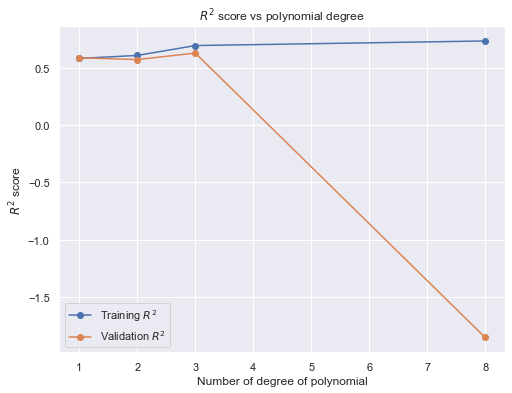

In [26]:
from sklearn.metrics import r2_score


x = [1,2,3,N]
models = [model_1, model_2, model_3, model_N]
X_trains = [X_train_df, X_train_df_2, X_train_df_3, X_train_df_N]
X_vals = [X_val_df, X_val_df_2, X_val_df_3, X_val_df_N]

r2_train = []
r2_val = []

for i,model in enumerate(models):
    y_pred_tra = model.predict(sm.add_constant(X_trains[i]))
    y_pred_val = model.predict(sm.add_constant(X_vals[i]))
    r2_train.append(r2_score(y_train, y_pred_tra))
    r2_val.append(r2_score(y_val, y_pred_val))
    
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x, r2_train, 'o-', label=r'Training $R^2$')
ax.plot(x, r2_val, 'o-', label=r'Validation $R^2$')
ax.set_xlabel('Number of degree of polynomial')
ax.set_ylabel(r'$R^2$ score')
ax.set_title(r'$R^2$ score vs polynomial degree')
ax.legend();

We notice a big difference between training and validation R^2 scores: seems like we are overfitting. **Introducing: regularization.**

## What about Multicollinearity?

There's seemingly a lot of multicollinearity in the data. Take a look at this warning that we got when showing our summary for our polynomial models: 

<img src="../fig/warning.png" width="400">

What is [multicollinearity](https://en.wikipedia.org/wiki/Multicollinearity)? Why do we have it in our dataset? Why is this a problem? 

Does regularization help solve the issue of multicollinearity? 

## What does Regularization help with?

We have some pretty large and extreme coefficient values in our most recent models. These coefficient values also have very high variance. We can also clearly see some overfitting to the training set. In order to reduce the coefficients of our parameters, we can introduce a penalty term that penalizes some of these extreme coefficient values. Specifically, regularization helps us: 

1. Avoid overfitting. Reduce features that have weak predictive power.
2. Discourage the use of a model that is too complex

<img src="../fig/overfit.png" width="600">

### Big Idea: Reduce Variance by Increasing Bias

Image Source: [here](https://www.cse.wustl.edu/~m.neumann/sp2016/cse517/lecturenotes/lecturenote12.html)

<img src="../fig/bias_variance.png" width="600">

## Ridge Regression

Ridge Regression is one such form of regularization. In practice, the ridge estimator reduces the complexity of the model by shrinking the coefficients, but it doesn’t nullify them. We control the amount of regularization using a parameter $\lambda$. **NOTE**: sklearn's [ridge regression package](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) represents this $\lambda$ using a parameter alpha. In Ridge Regression, the penalty term is proportional to the L2-norm of the coefficients. 

<img src="../fig/ridge.png" width="400">

## Lasso Regression

Lasso Regression is another form of regularization. Again, we control the amount of regularization using a parameter $\lambda$. **NOTE**: sklearn's [lasso regression package](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) represents this $\lambda$ using a parameter alpha. In Lasso Regression, the penalty term is proportional to the L1-norm of the coefficients. 

<img src="../fig/lasso.png" width="400">

### Some Differences between Ridge and Lasso Regression

1. Since Lasso regression tend to produce zero estimates for a number of model parameters - we say that Lasso solutions are **sparse** - we consider to be a method for variable selection.
2. In Ridge Regression, the penalty term is proportional to the L2-norm of the coefficients whereas in Lasso Regression, the penalty term is proportional to the L1-norm of the coefficients.
3. Ridge Regression has a closed form solution! Lasso Regression does not. We often have to solve this iteratively. In the sklearn package for Lasso regression, there is a parameter called `max_iter` that determines how many iterations we perform. 

### Why Standardizing Variables was not a waste of time

Lasso regression puts constraints on the size of the coefficients associated to each variable. However, this value will depend on the magnitude of each variable. It is therefore necessary to standardize the variables. 

## Let's use Ridge and Lasso to regularize our degree N polynomial

**Exercise**: Play around with different values of alpha. Notice the new $R^2$ value and also the range of values that the predictors take in the plot.

R squared score for our original OLS model: -1.856605980590993
R squared score for Ridge with alpha=100: 0.5869651490827922


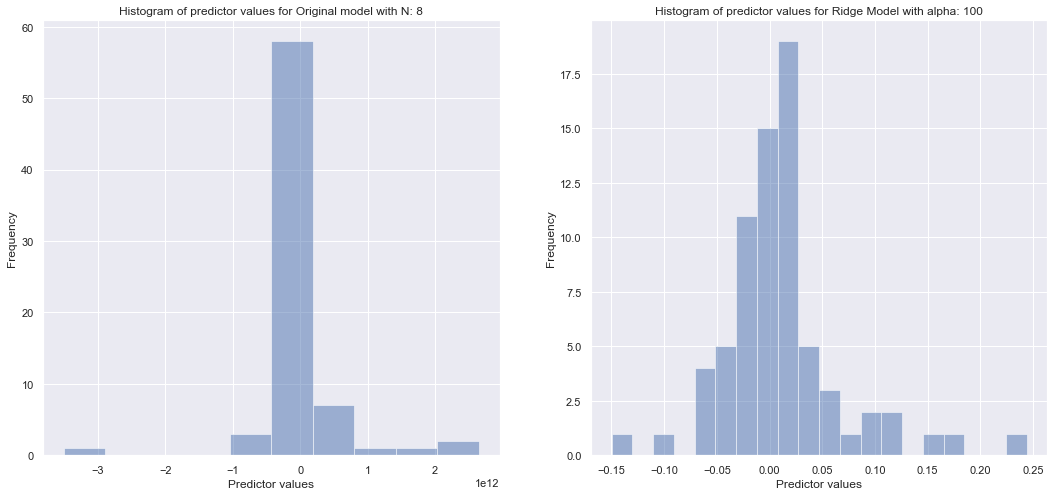

In [34]:
from sklearn.linear_model import Ridge

# some values you can try out: 0.01, 0.1, 0.5, 1, 5, 10, 20, 40, 100, 200, 500, 1000, 10000
alpha = 100
ridge_model = Ridge(alpha=alpha).fit(X_train_df_N, y_train)

print('R squared score for our original OLS model: {}'.format(r2_val[-1]))
print('R squared score for Ridge with alpha={}: {}'.format(alpha, ridge_model.score(X_val_df_N,y_val)))

fig, ax = plt.subplots(figsize=(18,8), ncols=2)
ax = ax.ravel()
ax[0].hist(model_N.params, bins=10, alpha=0.5)
ax[0].set_title('Histogram of predictor values for Original model with N: {}'.format(N))
ax[0].set_xlabel('Predictor values')
ax[0].set_ylabel('Frequency')

ax[1].hist(ridge_model.coef_.flatten(), bins=20, alpha=0.5)
ax[1].set_title('Histogram of predictor values for Ridge Model with alpha: {}'.format(alpha))
ax[1].set_xlabel('Predictor values')
ax[1].set_ylabel('Frequency');

R squared score for our original OLS model: -1.856605980590993
R squared score for Lasso with alpha=0.01: 0.5975930359800543


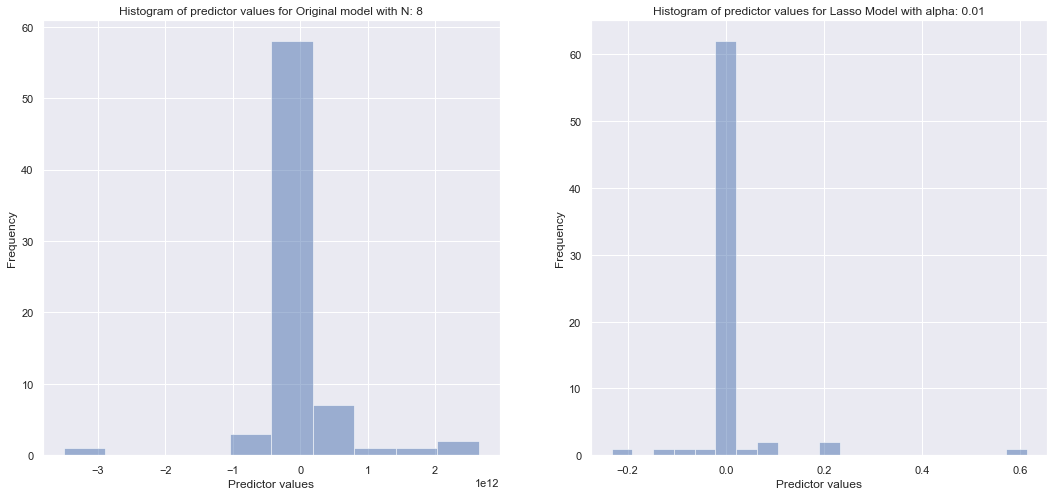

In [35]:
from sklearn.linear_model import Lasso

# some values you can try out: 0.00001, 0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10, 20
alpha = 0.01
lasso_model = Lasso(alpha=alpha, max_iter = 1000).fit(X_train_df_N, y_train)

print('R squared score for our original OLS model: {}'.format(r2_val[-1]))
print('R squared score for Lasso with alpha={}: {}'.format(alpha, lasso_model.score(X_val_df_N,y_val)))

fig, ax = plt.subplots(figsize=(18,8), ncols=2)
ax = ax.ravel()
ax[0].hist(model_N.params, bins=10, alpha=0.5)
ax[0].set_title('Histogram of predictor values for Original model with N: {}'.format(N))
ax[0].set_xlabel('Predictor values')
ax[0].set_ylabel('Frequency')

ax[1].hist(lasso_model.coef_.flatten(), bins=20, alpha=0.5)
ax[1].set_title('Histogram of predictor values for Lasso Model with alpha: {}'.format(alpha))
ax[1].set_xlabel('Predictor values')
ax[1].set_ylabel('Frequency');

## Model Selection and Cross-Validation

Here's our current setup so far: 

<img src="../fig/train_val_test.png" width="400">

So we try out 10,000 different models on our validation set and pick the one that's the best? No! **Since we could also be overfitting the validation set!** 

One solution to the problems raised by using a single validation set is to evaluate each model on multiple validation sets and average the validation performance. This is the essence of cross-validation!

<img src="../fig/cross_val.png" width="700">

Image source: [here](https://medium.com/@sebastiannorena/some-model-tuning-methods-bfef3e6544f0)

Let's give this a try using [RidgeCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html) and [LassoCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html):

In [36]:
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV

alphas = (0.001, 0.01, 0.1, 10, 100, 1000, 10000)

# Let us do k-fold cross validation 
k = 4
fitted_ridge = RidgeCV(alphas=alphas).fit(X_train_df_N, y_train)
fitted_lasso = LassoCV(alphas=alphas).fit(X_train_df_N, y_train)

print('R^2 score for our original OLS model: {}\n'.format(r2_val[-1]))

ridge_a = fitted_ridge.alpha_
print('Best alpha for ridge: {}'.format(ridge_a))
print('R^2 score for Ridge with alpha={}: {}\n'.format(ridge_a, fitted_ridge.score(X_val_df_N,y_val)))

lasso_a = fitted_lasso.alpha_
print('Best alpha for lasso: {}'.format(lasso_a))
print('R squared score for Lasso with alpha={}: {}'.format(lasso_a, fitted_lasso.score(X_val_df_N,y_val)))

R^2 score for our original OLS model: -1.856605980590993

Best alpha for ridge: 1000.0
R^2 score for Ridge with alpha=1000.0: 0.5779474940635883

Best alpha for lasso: 0.01
R squared score for Lasso with alpha=0.01: 0.5975930359800543


We can also look at the coefficients of our CV models.

**Final Step:** report the score on the test set for the model you have chosen to be the best.

----------------
### End of Standard Section
---------------